In [19]:
# import package
from dateutil import rrule
import urllib.request
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import json
import time
import ssl

stock = "6271"
begin_date = "2013-01-01"


%matplotlib inline

In [20]:
# 爬取每月股價的目標網站並包裝成函式
def craw_one_month(stock_number,date):
    url = (
        "https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date="+
        date.strftime('%Y%m%d')+
        "&stockNo="+
        stock_number
    )
    headers={"User-Agent":"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36 QIHU 360SE"}
    ssl._create_default_https_context = ssl._create_unverified_context
    req = urllib.request.Request(url, headers=headers)
    data = json.loads(urllib.request.urlopen(req).read())
    return pd.DataFrame(data['data'],columns=data['fields'])

In [21]:
# 根據使用者輸入的日期，以月為單位，重複呼叫爬取月股價的函式
def craw_stock(stock_number, start_month):
    b_month = datetime.date(*[int(x) for x in start_month.split('-')])
    now = datetime.datetime.now().strftime("%Y-%m-%d")         # 取得現在時間
    e_month = datetime.date(*[int(x) for x in now.split('-')])
    
    result = pd.DataFrame()
    for dt in rrule.rrule(rrule.MONTHLY, dtstart=b_month, until=e_month):
        result = pd.concat([result,craw_one_month(stock_number,dt)],ignore_index=True)
        time.sleep(2000.0/1000.0)
    
    return result

df = craw_stock(stock, begin_date)
df.set_index("日期", inplace=True)

In [22]:
df.to_csv(stock + '.csv', encoding='utf_8_sig')

In [23]:
# 如有個股當日停止交易
df = df[df['收盤價'] != '--']

In [6]:
# 如有個股 >= 1000，後續畫K線收盤價無須再轉換
df['收盤價'] = df['收盤價'].str.replace(',', '').astype(float)

Text(0, 0.5, 'stock')

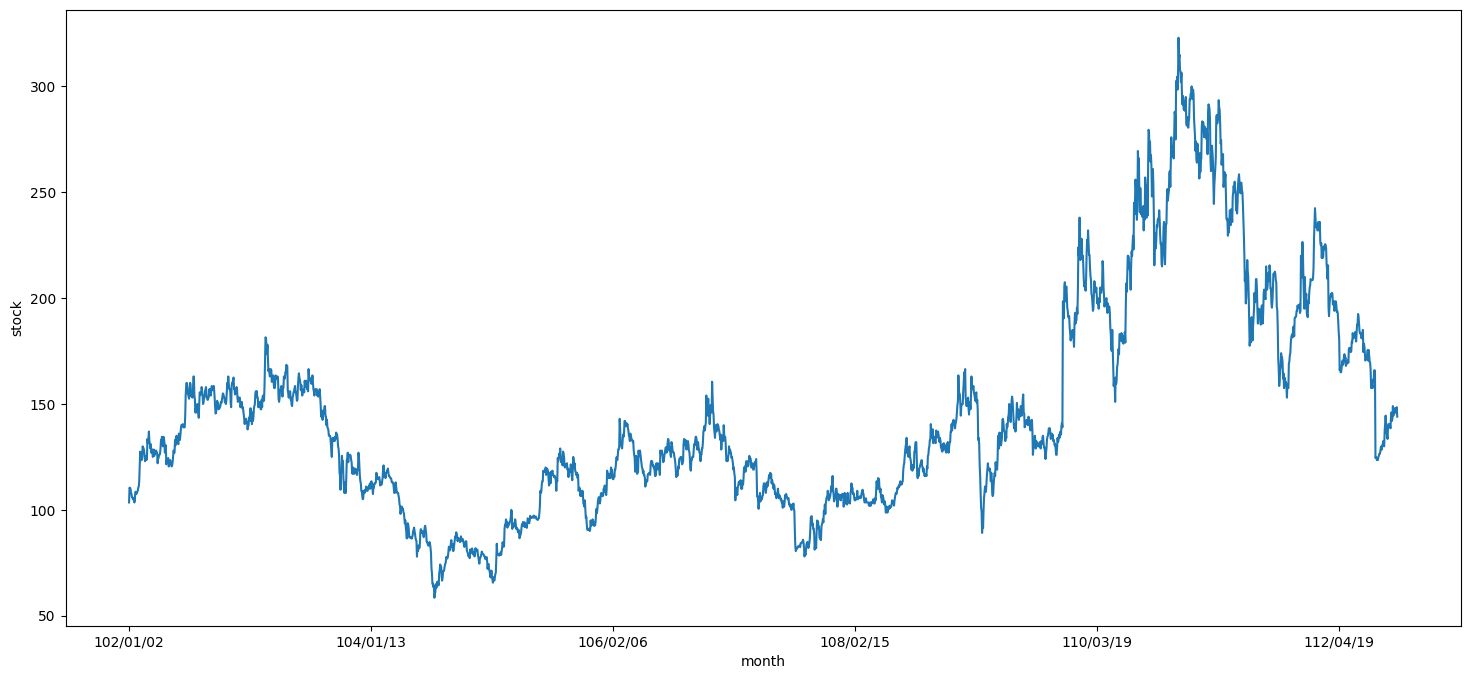

In [24]:
# 將爬取到的歷年股價資訊繪成圖表
df['收盤價']=df['收盤價'].astype(float)
df.loc[:]['收盤價'].plot(figsize=(18, 8))
plt.xlabel('month')
plt.ylabel('stock')

In [25]:
df = df.drop(['成交金額'], axis=1)
df = df.drop(['成交股數'], axis=1)
df.to_csv(stock + '.csv', encoding='utf_8_sig')

# 移至Technical Indicators繼續

In [26]:
import pandas as pd
import matplotlib
import mplfinance as mpf
# 導入pandas、matplotlib、mplfinance模組，將mplfinance模組縮寫為mpf
# 這邊要導入matplotlib的原因是因為mplfinance繪圖時需要調用mptplotlib模組

df = pd.read_csv('2454.csv', parse_dates=True, index_col=1) #讀取目標股票csv檔的位置

file_name = '2454.csv'
title = file_name.replace('.csv', '')

def custom_date_conversion(date_string):
    parts = date_string.split('/')
    year = int(parts[0]) + 1911  # 強制轉換年份
    month = int(parts[1])
    day = int(parts[2])
    return f"{year}/{month}/{day}"

# 使用 .apply() 方法應用自訂函數來轉換日期
df['日期'] = df['日期'].apply(custom_date_conversion)

df['日期'] = pd.to_datetime(df['日期']) #將日期轉為datetime格式

df.set_index('日期', inplace=False)  # 將 '日期' 列設置為索引

# 重置索引，將 '開盤價' 移回到新的列
df = df.reset_index(inplace=False)

# 變換欄位
df = df[['日期', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數']]

df.set_index('日期', inplace=True)  # 將 '日期' 列設置為索引

# 重置索引，將 '開盤價' 移回到新的列
df = df.reset_index()                              

df.set_index('日期', inplace=True)

df['開盤價'] = df['開盤價'].str.replace(',', '').astype(float)
df['收盤價'] = df['收盤價'].str.replace(',', '').astype(float)
df['最高價'] = df['最高價'].str.replace(',', '').astype(float)
df['最低價'] = df['最低價'].str.replace(',', '').astype(float)
df['成交筆數'] = df['成交筆數'].str.replace(',', '').astype(int)

df.rename(columns={'成交筆數':'Volume'}, inplace = True) 
#這裡針對資料表做一下修正，因為交易量(Turnover)在mplfinance中須被改為Volume才能被認出來

df.rename(columns={'開盤價':'Open'}, inplace=True)
df.rename(columns={'最高價':'High'}, inplace=True)
df.rename(columns={'最低價':'Low'}, inplace=True)
df.rename(columns={'收盤價':'Close'}, inplace=True)
df.rename(columns={'漲跌價差':'Spread'}, inplace=True)

mc = mpf.make_marketcolors(up='r',down='g',inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='yahoo',marketcolors=mc)
#針對線圖的外觀微調，將上漲設定為紅色，下跌設定為綠色，符合台股表示習慣
#接著把自訂的marketcolors放到自訂的style中，而這個改動是基於預設的yahoo外觀

kwargs = dict(type='candle', mav=(5,20,60), volume=True, figratio=(20,16), figscale=0.75, title=title, style=s)
#設定可變參數kwargs，並在變數中填上繪圖時會用到的設定值

mpf.plot(df, **kwargs)
#選擇df資料表為資料來源，帶入kwargs參數，畫出目標股票的走勢圖

C:\Users\USER\AppData\Local\Temp\ipykernel_19152\2334588761.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('2454.csv', parse_dates=True, index_col=1) #讀取目標股票csv檔的位置


ValueError: invalid literal for int() with base 10: '2013-01-02'

In [24]:
df

,Open,High,Low,Close,Spread,Volume
日期,,,,,,
2013-01-02,324.5,325.0,322.0,325.0,+1.50,4339
2013-01-03,327.0,329.0,325.5,326.0,+1.00,6370
2013-01-04,308.0,314.0,304.5,305.5,-20.50,15766
2013-01-07,301.5,302.5,295.0,301.5,-4.00,10118
2013-01-08,300.0,303.0,299.0,302.5,+1.00,6754
...,...,...,...,...,...,...
2023-10-06,790.0,790.0,781.0,786.0,0.00,6465
2023-10-11,790.0,816.0,790.0,814.0,+28.00,23063
2023-10-12,817.0,819.0,805.0,815.0,+1.00,10182


In [25]:
df.to_csv(stock + '.csv', encoding='utf_8_sig')

In [34]:
df = pd.read_csv('2317.csv', parse_dates=True, index_col=1) #讀取目標股票csv檔的位置

def convert_to_gregorian_date(date_string):
    parts = date_string.split('/')
    year = int(parts[0]) + 1911
    new_date = f"{year}/{parts[1]}/{parts[2]}"
    return new_date

df['新日期'] = df['日期'].apply(convert_to_gregorian_date)

C:\Users\USER\AppData\Local\Temp\ipykernel_16716\3209734945.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('2317.csv', parse_dates=True, index_col=1) #讀取目標股票csv檔的位置


In [35]:
df

,日期,最高價,最低價,收盤價,漲跌價差,成交筆數,新日期
開盤價,,,,,,,
99.9,112/01/03,99.9,98.0,99.1,-0.80,"37,746",2023/01/03
98.0,112/01/04,98.7,98.0,98.1,-1.00,"34,793",2023/01/04
98.1,112/01/05,98.9,98.0,98.0,-0.10,"26,593",2023/01/05
98.3,112/01/06,98.8,98.3,98.4,+0.40,"16,660",2023/01/06
99.2,112/01/09,99.6,98.9,99.1,+0.70,"19,622",2023/01/09
...,...,...,...,...,...,...,...
103.0,112/10/04,103.5,102.5,103.0,-1.00,"18,392",2023/10/04
103.0,112/10/05,104.0,103.0,103.5,+0.50,"8,814",2023/10/05
105.0,112/10/06,106.0,104.5,105.5,+2.00,"12,925",2023/10/06


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 99.9 to 106.5
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   日期      183 non-null    object 
 1   最高價     183 non-null    float64
 2   最低價     183 non-null    float64
 3   收盤價     183 non-null    float64
 4   漲跌價差    183 non-null    object 
 5   成交筆數    183 non-null    object 
dtypes: float64(3), object(3)
memory usage: 10.0+ KB


In [3]:
df = pd.read_csv('2330.csv', parse_dates=True, index_col=1) #讀取目標股票csv檔的位置

df['日期'] = pd.to_datetime(df['日期']) #將日期轉為datetime格式

df.set_index('日期', inplace=False)  # 將 '日期' 列設置為索引

# 重置索引，將 '開盤價' 移回到新的列
df = df.reset_index(inplace=False)

print(df)

       開盤價         日期    最高價    最低價    收盤價  漲跌價差    成交筆數
0    446.0 2023-01-03  453.5  443.0  453.0   4.5  22,581
1    449.5 2023-01-04  455.0  448.5  449.5  -3.5  18,233
2    459.0 2023-01-05  459.5  455.0  458.5     9  20,752
3    455.0 2023-01-06  459.5  455.0  458.5     0  16,635
4    468.0 2023-01-09  481.0  467.5  481.0  22.5  57,305
..     ...        ...    ...    ...    ...   ...     ...
177  528.0 2023-10-03  533.0  528.0  529.0    -4  17,430
178  521.0 2023-10-04  523.0  519.0  520.0    -9  49,176
179  523.0 2023-10-05  529.0  523.0  528.0     8  19,027
180  530.0 2023-10-06  533.0  529.0  532.0     4  14,047
181  542.0 2023-10-11  544.0  540.0  544.0    12  43,385

[182 rows x 7 columns]


C:\Users\USER\AppData\Local\Temp\ipykernel_16716\494719456.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('2330.csv', parse_dates=True, index_col=1) #讀取目標股票csv檔的位置


In [4]:
df

,開盤價,日期,最高價,最低價,收盤價,漲跌價差,成交筆數
0,446.0,2023-01-03,453.5,443.0,453.0,4.5,"22,581"
1,449.5,2023-01-04,455.0,448.5,449.5,-3.5,"18,233"
2,459.0,2023-01-05,459.5,455.0,458.5,9,"20,752"
3,455.0,2023-01-06,459.5,455.0,458.5,0,"16,635"
4,468.0,2023-01-09,481.0,467.5,481.0,22.5,"57,305"
...,...,...,...,...,...,...,...
177,528.0,2023-10-03,533.0,528.0,529.0,-4,"17,430"
178,521.0,2023-10-04,523.0,519.0,520.0,-9,"49,176"
179,523.0,2023-10-05,529.0,523.0,528.0,8,"19,027"
180,530.0,2023-10-06,533.0,529.0,532.0,4,"14,047"


In [7]:


# 根據使用者輸入的日期，以月為單位，重複呼叫爬取月股價的函式
def craw_stock(stock_number, start_month):
    b_month = datetime.date(*[int(x) for x in start_month.split('-')])
    now = datetime.datetime.now().strftime("%Y-%m-%d")         # 取得現在時間
    e_month = datetime.date(*[int(x) for x in now.split('-')])
    
    result = pd.DataFrame()
    for dt in rrule.rrule(rrule.MONTHLY, dtstart=b_month, until=e_month):
        result = pd.concat([result,craw_one_month(stock_number,dt)],ignore_index=True)
        time.sleep(2000.0/1000.0)
    
    return result

df = craw_stock(stock, begin_date)
df.set_index("日期", inplace=True)

Text(0, 0.5, 'stock')

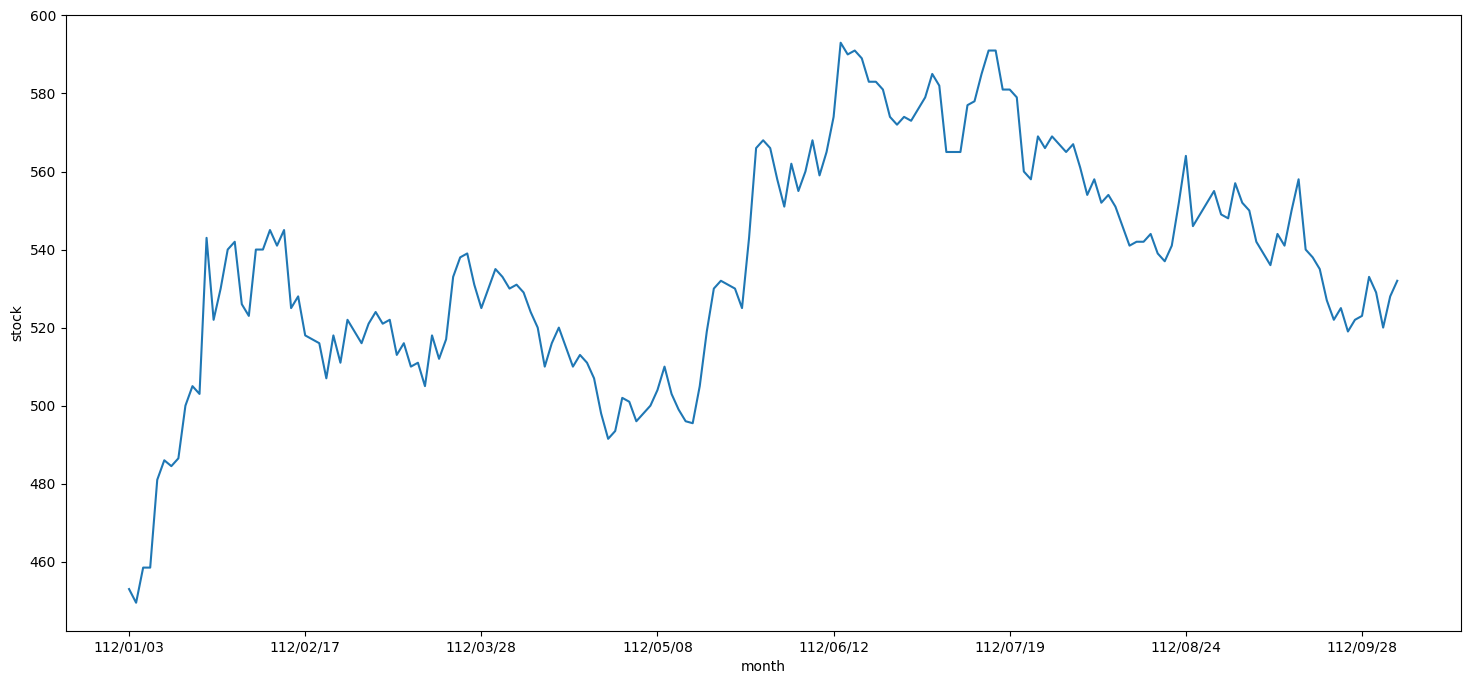

In [12]:
# 將爬取到的歷年股價資訊繪成圖表
df['收盤價']=df['收盤價'].astype(float)
df.loc[:]['收盤價'].plot(figsize=(18, 8))
plt.xlabel('month')
plt.ylabel('stock')

In [8]:
df = df.drop(['成交金額'], axis=1)
df = df.drop(['成交股數'], axis=1)
df.to_csv(stock + '.csv', encoding='utf_8_sig')

In [93]:
# 讀取CSV檔並將日期解析為datetime，同時設置'日期'列為索引
df = pd.read_csv('2330.csv', parse_dates=True, index_col=1) #讀取目標股票csv檔的位置

df['日期'] = pd.to_datetime(df['日期']) #將日期轉為datetime格式

df.set_index('日期', inplace=False)  # 將 '日期' 列設置為索引

# 重置索引，將 '開盤價' 移回到新的列
df = df.reset_index(inplace=False)

df

C:\Users\USER\AppData\Local\Temp\ipykernel_10680\2597512021.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('2330.csv', parse_dates=True, index_col=1) #讀取目標股票csv檔的位置


,開盤價,日期,最高價,最低價,收盤價,漲跌價差,成交筆數
0,446.0,2023-01-03,453.5,443.0,453.0,4.5,"22,581"
1,449.5,2023-01-04,455.0,448.5,449.5,-3.5,"18,233"
2,459.0,2023-01-05,459.5,455.0,458.5,9,"20,752"
3,455.0,2023-01-06,459.5,455.0,458.5,0,"16,635"
4,468.0,2023-01-09,481.0,467.5,481.0,22.5,"57,305"
...,...,...,...,...,...,...,...
177,528.0,2023-10-03,533.0,528.0,529.0,-4,"17,430"
178,521.0,2023-10-04,523.0,519.0,520.0,-9,"49,176"
179,523.0,2023-10-05,529.0,523.0,528.0,8,"19,027"
180,530.0,2023-10-06,533.0,529.0,532.0,4,"14,047"
